In [139]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import train & test data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

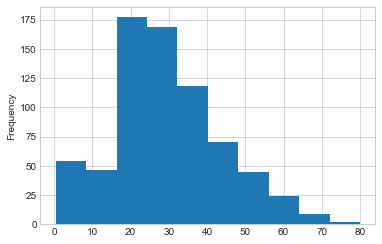

In [3]:
train.Age.plot.hist()

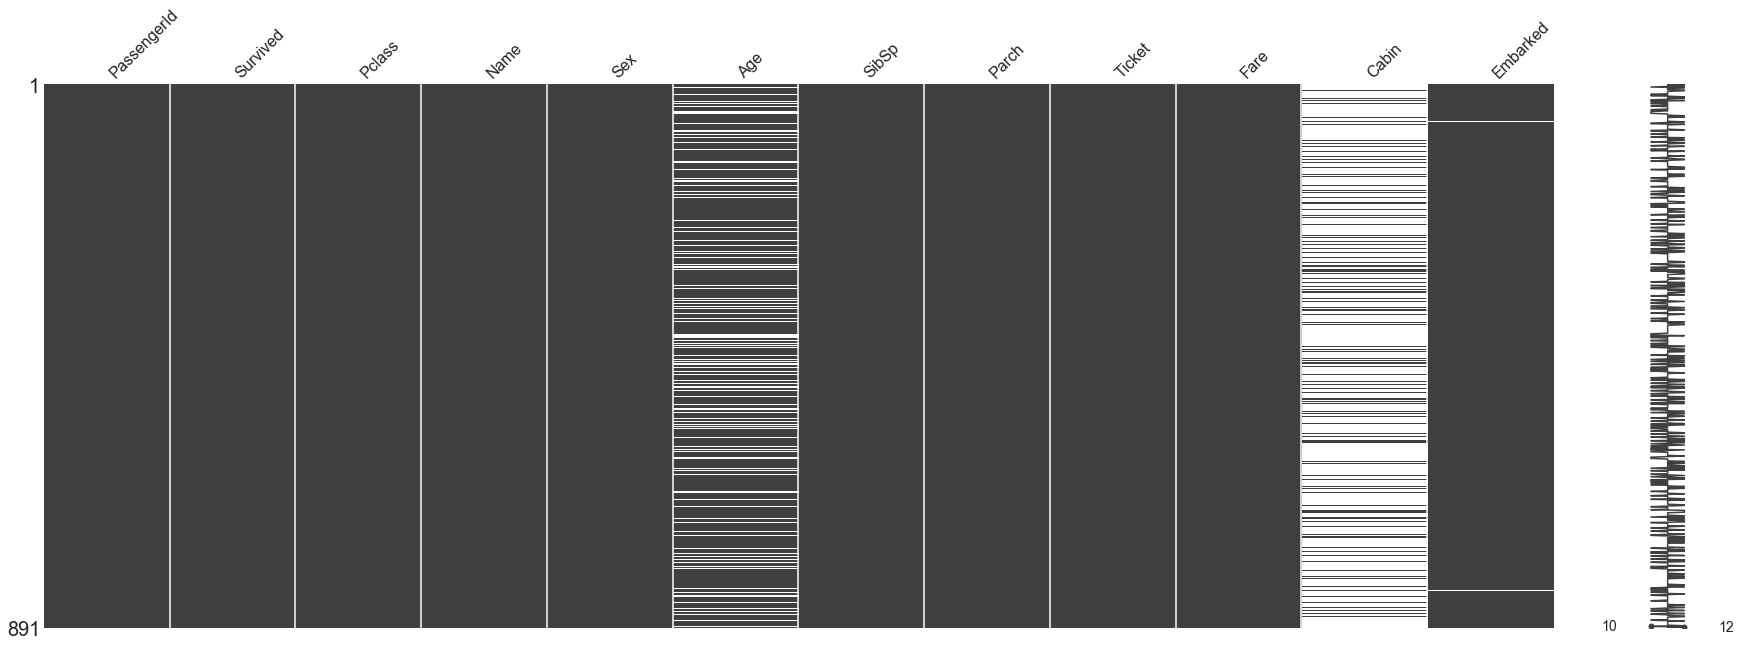

In [4]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

0    549
1    342
Name: Survived, dtype: int64


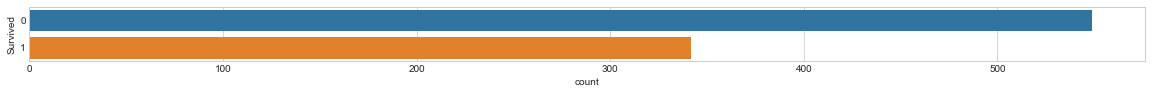

In [5]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [6]:
# How many different names are there?
train.Name.value_counts()

Reeves, Mr. David              1
Robbins, Mr. Victor            1
Allen, Mr. William Henry       1
Wiklund, Mr. Jakob Alfred      1
Hansen, Mr. Henrik Juul        1
                              ..
Hickman, Mr. Leonard Mark      1
Turcin, Mr. Stjepan            1
Dodge, Master. Washington      1
Williams, Mr. Charles Duane    1
Fox, Mr. Stanley Hubert        1
Name: Name, Length: 891, dtype: int64

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df_bin = pd.DataFrame()
df_con = pd.DataFrame()

In [9]:
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

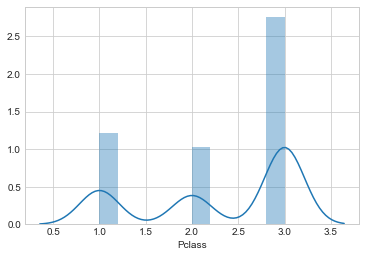

In [10]:
sns.distplot(train.Pclass)

In [11]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [12]:
train.Name.value_counts()

Reeves, Mr. David              1
Robbins, Mr. Victor            1
Allen, Mr. William Henry       1
Wiklund, Mr. Jakob Alfred      1
Hansen, Mr. Henrik Juul        1
                              ..
Hickman, Mr. Leonard Mark      1
Turcin, Mr. Stjepan            1
Dodge, Master. Washington      1
Williams, Mr. Charles Duane    1
Fox, Mr. Stanley Hubert        1
Name: Name, Length: 891, dtype: int64

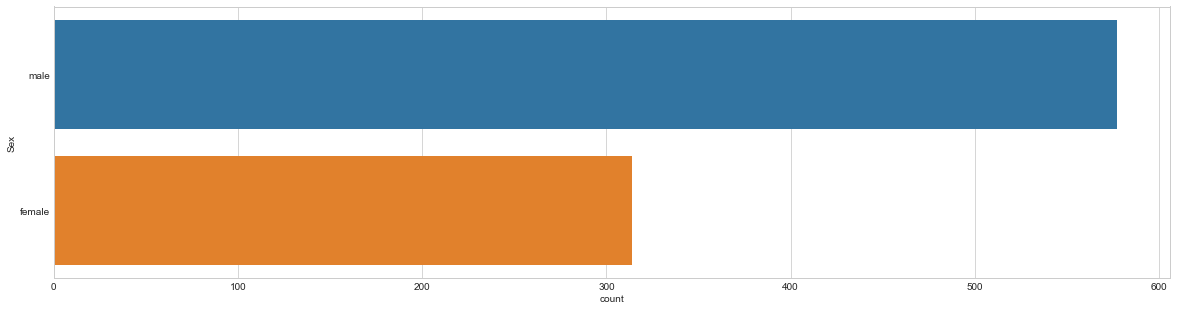

In [13]:
plt.figure(figsize=(20,5))
sns.countplot(y='Sex',data=train);

In [14]:
train.Sex.isnull().sum()

0

In [15]:
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex']=='female',1,0)
df_con['Sex'] = train['Sex']

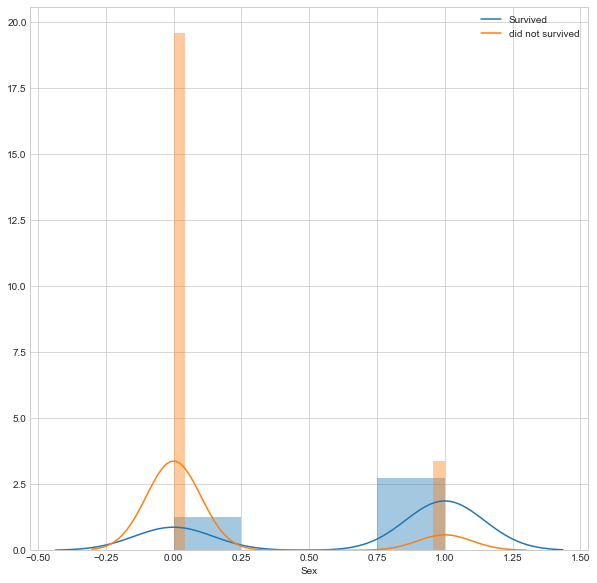

In [16]:
fig = plt.figure(figsize=(10,10))
sns.distplot(df_bin.loc[df_bin['Survived']==1]['Sex'],kde_kws={'label':'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived']==0]['Sex'],kde_kws={'label':'did not survived'})

In [17]:
train.Age.isnull().sum()

177

In [19]:
df_bin

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0
...,...,...,...
886,0,2,0
887,1,1,1
888,0,3,1
889,1,1,0


In [27]:
data = [train,test]
for dataset in data:
    mean = train['Age'].mean()
    std  = train['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    rand_age = np.random.randint(mean-std,mean+std,size=is_null)
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)]=rand_age
    dataset['Age'] = age_slice
    dataset['Age'] = train['Age'].astype(int)
train['Age'].isnull().sum()

0

In [31]:
common_value = 'S'
data = [train,test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

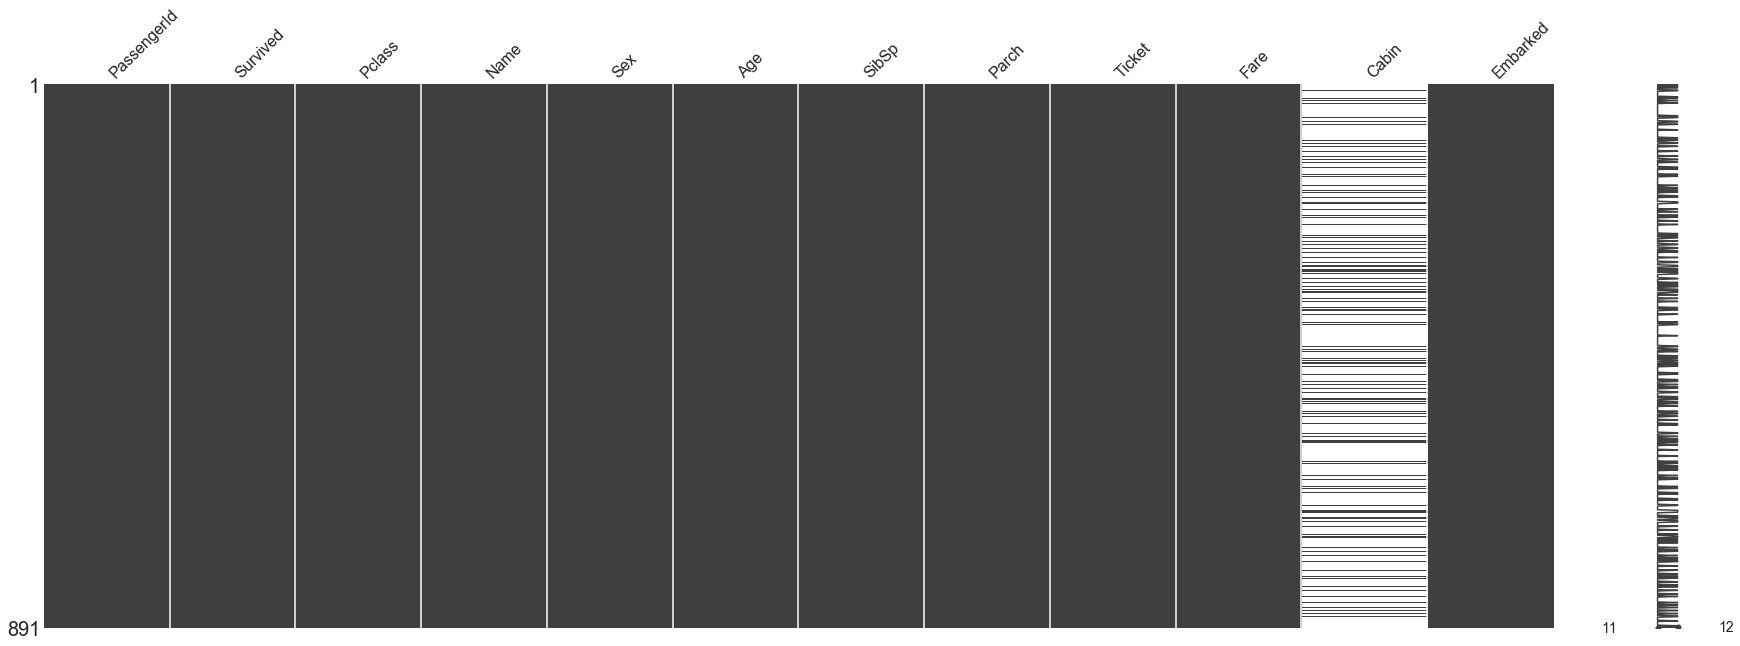

In [32]:
missingno.matrix(train,figsize=(30,10))

In [33]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x:re.compile("([a-zA-Z+])").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] =  dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
train = train.drop(['Cabin'],axis=1)
test = test.drop(['Cabin'],axis=1)

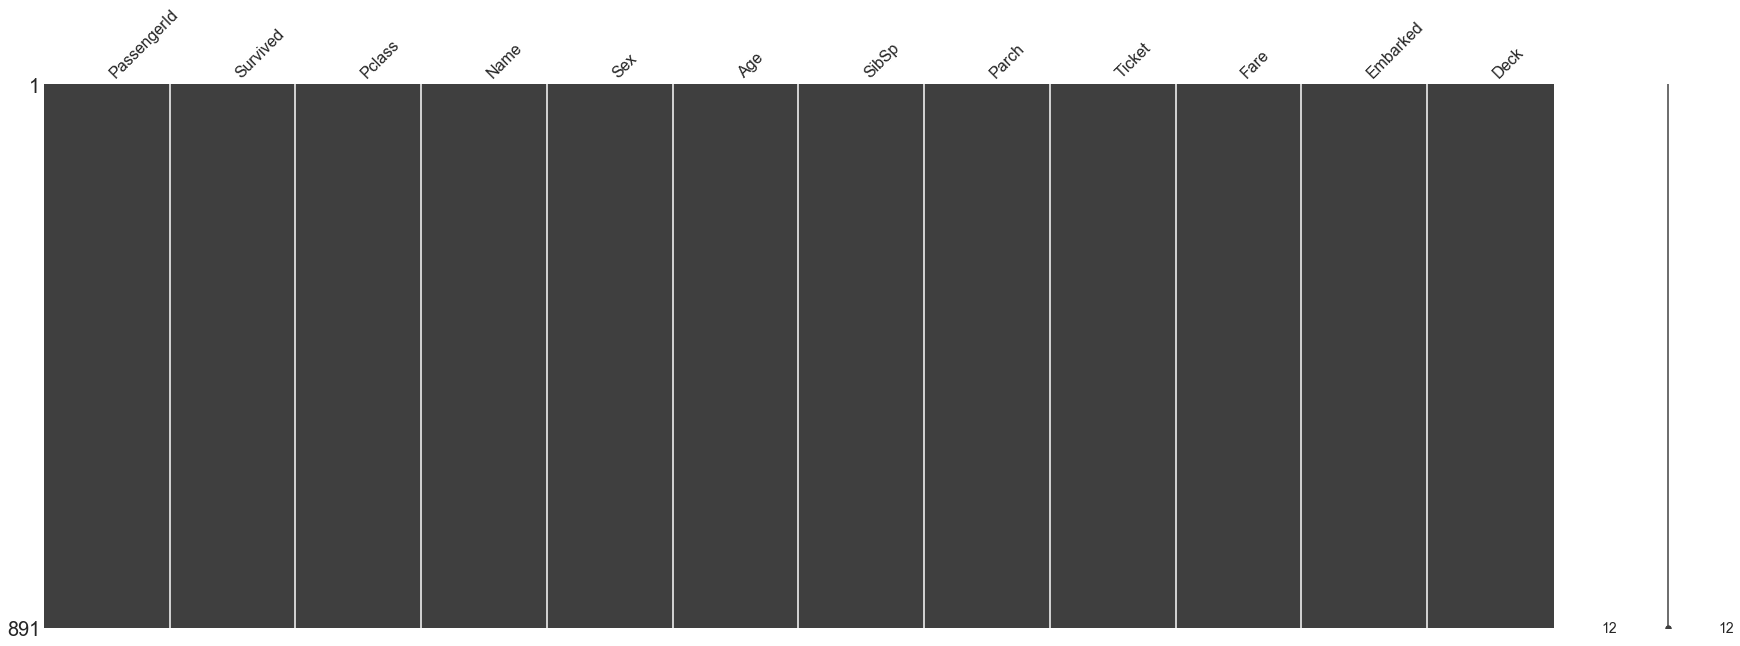

In [35]:
missingno.matrix(train,figsize=(30,10))

In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null int32
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Embarked       418 non-null object
Deck           418 non-null int32
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 32.8+ KB


In [39]:
train['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [43]:
train['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [53]:
df_bin['Age'] = train['Age']

In [59]:
train.Fare.dtype

dtype('float64')

In [60]:
len(train.Fare.unique())

248

In [61]:
df_con['Fare'] = train['Fare']
df_bin['Fare'] = pd.cut(train['Fare'],bins=5)

In [70]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [73]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
891


In [74]:
df_bin.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,0,22,"(-0.512, 102.466]",S
1,1,1,1,38,"(-0.512, 102.466]",C
2,1,3,1,26,"(-0.512, 102.466]",S
3,1,1,1,35,"(-0.512, 102.466]",S
4,0,3,0,35,"(-0.512, 102.466]",S


In [76]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

In [86]:
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

In [87]:
df_bin.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,SibSp,Parch
0,0,3,0,22,"(-0.512, 102.466]",S,1,0
1,1,1,1,38,"(-0.512, 102.466]",C,1,0
2,1,3,1,26,"(-0.512, 102.466]",S,0,0
3,1,1,1,35,"(-0.512, 102.466]",S,1,0
4,0,3,0,35,"(-0.512, 102.466]",S,0,0
5,0,3,0,35,"(-0.512, 102.466]",Q,0,0
6,0,1,0,54,"(-0.512, 102.466]",S,0,0
7,0,3,0,2,"(-0.512, 102.466]",S,3,1
8,1,3,1,27,"(-0.512, 102.466]",S,0,2
9,1,2,1,14,"(-0.512, 102.466]",C,1,0


In [88]:
df_con.head()

,Survived,Pclass,Sex,Fare,Embarked,SibSp,Parch
0,0,3,male,7.2500,S,1,0
1,1,1,female,71.2833,C,1,0
2,1,3,female,7.9250,S,0,0
3,1,1,female,53.1000,S,1,0
4,0,3,male,8.0500,S,0,0


In [91]:
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin,columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Age_0,Age_1,Age_2,Age_3,...,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [92]:
df_con.head(10)

,Survived,Pclass,Sex,Fare,Embarked,SibSp,Parch
0,0,3,male,7.2500,S,1,0
1,1,1,female,71.2833,C,1,0
2,1,3,female,7.9250,S,0,0
3,1,1,female,53.1000,S,1,0
4,0,3,male,8.0500,S,0,0
5,0,3,male,8.4583,Q,0,0
6,0,1,male,51.8625,S,0,0
7,0,3,male,21.0750,S,3,1
8,1,3,female,11.1333,S,0,2
9,1,2,female,30.0708,C,1,0


In [93]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [94]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [95]:
df_con_enc.head(20)

,Survived,Fare,SibSp,Parch,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,7.2500,1,0,0,0,1,0,1,0,0,1
1,1,71.2833,1,0,1,0,0,1,0,1,0,0
2,1,7.9250,0,0,0,0,1,1,0,0,0,1
3,1,53.1000,1,0,0,0,1,1,0,1,0,0
4,0,8.0500,0,0,0,0,1,0,1,0,0,1
5,0,8.4583,0,0,0,1,0,0,1,0,0,1
6,0,51.8625,0,0,0,0,1,0,1,1,0,0
7,0,21.0750,3,1,0,0,1,0,1,0,0,1
8,1,11.1333,0,2,0,0,1,1,0,0,0,1
9,1,30.0708,1,0,1,0,0,1,0,0,1,0


In [96]:
selected_df = df_con_enc

In [97]:
selected_df.head()

,Survived,Fare,SibSp,Parch,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,7.2500,1,0,0,0,1,0,1,0,0,1
1,1,71.2833,1,0,1,0,0,1,0,1,0,0
2,1,7.9250,0,0,0,0,1,1,0,0,0,1
3,1,53.1000,1,0,0,0,1,1,0,1,0,0
4,0,8.0500,0,0,0,0,1,0,1,0,0,1


In [98]:
X_train = selected_df.drop('Survived',axis=1)
y_train = selected_df.Survived

In [99]:
X_train.shape

(891, 11)

In [100]:
X_train.head()

,Fare,SibSp,Parch,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,7.2500,1,0,0,0,1,0,1,0,0,1
1,71.2833,1,0,1,0,0,1,0,1,0,0
2,7.9250,0,0,0,0,1,1,0,0,0,1
3,53.1000,1,0,0,0,1,1,0,1,0,0
4,8.0500,0,0,0,0,1,0,1,0,0,1


In [101]:
y_train.shape

(891,)

In [102]:
def fit_ml_algo(algo,X_train,y_train,cv):
    model = algo.fit(X_train,y_train)
    acc = round(model.score(X_train,y_train)*100,2)
    
    train_pred = model_selection.cross_val_predict(algo,
                                                    X_train,
                                                    y_train,cv=cv,
                                                    n_jobs=-1)
    acc_cv = round(metrics.accuracy_score(y_train,train_pred)*100,2)
    return train_pred,acc,acc_cv

In [109]:
#logistic regression
start_time = time.time()
train_pred_log,acc_log,acc_cv_log = fit_ml_algo(LogisticRegression(),X_train,
                                                y_train,10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.02
Accuracy CV 10-Fold: 79.46
Running Time: 0:00:00.108609


In [112]:
#k-nearest neighbour
start_time = time.time()
train_pred_knn,acc_knn,acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),X_train,
                                                y_train,10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.61
Accuracy CV 10-Fold: 76.99
Running Time: 0:00:00.152830


In [113]:
#gaussian naice bayes
start_time = time.time()
train_pred_gaussian,acc_gaussian,acc_cv_gaussian = fit_ml_algo(GaussianNB(),X_train,
                                                y_train,10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.56
Accuracy CV 10-Fold: 78.56
Running Time: 0:00:00.092288


In [114]:
#Stochastic gradient descent
start_time = time.time()
train_pred_sgd,acc_sgd,acc_cv_sgd = fit_ml_algo(SGDClassifier(),X_train,
                                                y_train,10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 61.62
Accuracy CV 10-Fold: 70.03
Running Time: 0:00:00.128362


In [127]:
#linear support vector machine
start_time = time.time()
train_pred_svc,acc_linear_svc,acc_cv_linear_svc = fit_ml_algo(LinearSVC(),X_train,
                                                y_train,10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 80.13
Accuracy CV 10-Fold: 75.2
Running Time: 0:00:07.448735


In [116]:
#DEcision Tree Classifier
start_time = time.time()
train_pred_dt,acc_dt,acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(),X_train,
                                                y_train,10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.48
Accuracy CV 10-Fold: 80.7
Running Time: 0:00:00.160608


In [117]:
#Gradient Bootsting Trees
start_time = time.time()
train_pred_gbt,acc_gbt,acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),X_train,
                                                y_train,10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 87.21
Accuracy CV 10-Fold: 81.26
Running Time: 0:00:05.965042


In [119]:
cat_features =  np.where(X_train.dtypes!=np.float)[0]
cat_features

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [120]:
train_pool = Pool(X_train,y_train,cat_features)

In [121]:
catboost_model = CatBoostClassifier(iterations=1000,custom_loss=['Accuracy'],
                                   loss_function='Logloss')

catboost_model.fit(train_pool,plot=True)
acc_catboost = round(catboost_model.score(X_train,y_train)*100,2)

Learning rate set to 0.016216
0:	learn: 0.6815056	total: 211ms	remaining: 3m 31s
1:	learn: 0.6716773	total: 256ms	remaining: 2m 7s
2:	learn: 0.6632980	total: 267ms	remaining: 1m 28s
3:	learn: 0.6552440	total: 268ms	remaining: 1m 6s
4:	learn: 0.6453423	total: 277ms	remaining: 55s
5:	learn: 0.6373703	total: 293ms	remaining: 48.5s
6:	learn: 0.6294840	total: 304ms	remaining: 43.2s
7:	learn: 0.6208795	total: 318ms	remaining: 39.5s
8:	learn: 0.6158415	total: 327ms	remaining: 36s
9:	learn: 0.6097112	total: 335ms	remaining: 33.1s
10:	learn: 0.6037115	total: 345ms	remaining: 31s
11:	learn: 0.5967502	total: 356ms	remaining: 29.4s
12:	learn: 0.5889958	total: 379ms	remaining: 28.8s
13:	learn: 0.5823007	total: 391ms	remaining: 27.5s
14:	learn: 0.5788372	total: 399ms	remaining: 26.2s
15:	learn: 0.5729525	total: 423ms	remaining: 26s
16:	learn: 0.5664343	total: 448ms	remaining: 25.9s
17:	learn: 0.5622452	total: 456ms	remaining: 24.9s


18:	learn: 0.5562195	total: 478ms	remaining: 24.7s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

19:	learn: 0.5523666	total: 545ms	remaining: 26.7s
20:	learn: 0.5481956	total: 548ms	remaining: 25.6s
21:	learn: 0.5432413	total: 552ms	remaining: 24.6s
22:	learn: 0.5388046	total: 565ms	remaining: 24s
23:	learn: 0.5352500	total: 575ms	remaining: 23.4s
24:	learn: 0.5315939	total: 587ms	remaining: 22.9s
25:	learn: 0.5291641	total: 589ms	remaining: 22.1s
26:	learn: 0.5252762	total: 598ms	remaining: 21.6s
27:	learn: 0.5225969	total: 607ms	remaining: 21.1s
28:	learn: 0.5190837	total: 610ms	remaining: 20.4s
29:	learn: 0.5171952	total: 612ms	remaining: 19.8s
30:	learn: 0.5136771	total: 626ms	remaining: 19.6s
31:	learn: 0.5119306	total: 628ms	remaining: 19s
32:	learn: 0.5084167	total: 639ms	remaining: 18.7s
33:	learn: 0.5060633	total: 645ms	remaining: 18.3s
34:	learn: 0.5030928	total: 654ms	remaining: 18s
35:	learn: 0.5008388	total: 676ms	remaining: 18.1s
36:	learn: 0.4977735	total: 694ms	remaining: 18.1s
37:	learn: 0.4949589	total: 705ms	remaining: 17.8s
38:	learn: 0.4936342	total: 708ms	rem

189:	learn: 0.3944556	total: 2.19s	remaining: 9.36s
190:	learn: 0.3943306	total: 2.2s	remaining: 9.33s
191:	learn: 0.3939199	total: 2.21s	remaining: 9.3s
192:	learn: 0.3936967	total: 2.22s	remaining: 9.29s
193:	learn: 0.3934701	total: 2.23s	remaining: 9.27s
194:	learn: 0.3934689	total: 2.23s	remaining: 9.21s
195:	learn: 0.3933168	total: 2.26s	remaining: 9.26s
196:	learn: 0.3932577	total: 2.27s	remaining: 9.23s
197:	learn: 0.3928603	total: 2.27s	remaining: 9.2s
198:	learn: 0.3927246	total: 2.3s	remaining: 9.24s
199:	learn: 0.3924758	total: 2.31s	remaining: 9.23s
200:	learn: 0.3923141	total: 2.32s	remaining: 9.21s
201:	learn: 0.3922688	total: 2.32s	remaining: 9.18s
202:	learn: 0.3921521	total: 2.34s	remaining: 9.19s
203:	learn: 0.3920065	total: 2.34s	remaining: 9.15s
204:	learn: 0.3918742	total: 2.35s	remaining: 9.11s
205:	learn: 0.3917568	total: 2.36s	remaining: 9.09s
206:	learn: 0.3915910	total: 2.36s	remaining: 9.06s
207:	learn: 0.3912260	total: 2.37s	remaining: 9.04s
208:	learn: 0.39

363:	learn: 0.3689402	total: 3.82s	remaining: 6.68s
364:	learn: 0.3689105	total: 3.83s	remaining: 6.66s
365:	learn: 0.3689098	total: 3.83s	remaining: 6.64s
366:	learn: 0.3688821	total: 3.83s	remaining: 6.61s
367:	learn: 0.3688820	total: 3.83s	remaining: 6.59s
368:	learn: 0.3687899	total: 3.85s	remaining: 6.59s
369:	learn: 0.3687718	total: 3.86s	remaining: 6.57s
370:	learn: 0.3685770	total: 3.87s	remaining: 6.57s
371:	learn: 0.3685770	total: 3.87s	remaining: 6.54s
372:	learn: 0.3684117	total: 3.88s	remaining: 6.53s
373:	learn: 0.3683429	total: 3.89s	remaining: 6.5s
374:	learn: 0.3681551	total: 3.89s	remaining: 6.49s
375:	learn: 0.3680501	total: 3.91s	remaining: 6.49s
376:	learn: 0.3679144	total: 3.92s	remaining: 6.47s
377:	learn: 0.3677951	total: 3.92s	remaining: 6.45s
378:	learn: 0.3677654	total: 3.94s	remaining: 6.45s
379:	learn: 0.3677045	total: 3.95s	remaining: 6.45s
380:	learn: 0.3676157	total: 3.96s	remaining: 6.43s
381:	learn: 0.3674669	total: 3.97s	remaining: 6.42s
382:	learn: 0

532:	learn: 0.3513255	total: 5.28s	remaining: 4.62s
533:	learn: 0.3511689	total: 5.3s	remaining: 4.63s
534:	learn: 0.3509358	total: 5.32s	remaining: 4.63s
535:	learn: 0.3508104	total: 5.34s	remaining: 4.62s
536:	learn: 0.3507325	total: 5.34s	remaining: 4.61s
537:	learn: 0.3504996	total: 5.36s	remaining: 4.6s
538:	learn: 0.3504598	total: 5.36s	remaining: 4.58s
539:	learn: 0.3503505	total: 5.38s	remaining: 4.58s
540:	learn: 0.3502758	total: 5.38s	remaining: 4.56s
541:	learn: 0.3501140	total: 5.38s	remaining: 4.55s
542:	learn: 0.3499391	total: 5.39s	remaining: 4.54s
543:	learn: 0.3498275	total: 5.41s	remaining: 4.53s
544:	learn: 0.3496293	total: 5.42s	remaining: 4.52s
545:	learn: 0.3495219	total: 5.43s	remaining: 4.51s
546:	learn: 0.3493298	total: 5.46s	remaining: 4.52s
547:	learn: 0.3492483	total: 5.47s	remaining: 4.51s
548:	learn: 0.3491519	total: 5.49s	remaining: 4.51s
549:	learn: 0.3490833	total: 5.5s	remaining: 4.5s
550:	learn: 0.3490695	total: 5.5s	remaining: 4.48s
551:	learn: 0.348

698:	learn: 0.3305182	total: 7.37s	remaining: 3.17s
699:	learn: 0.3305018	total: 7.38s	remaining: 3.16s
700:	learn: 0.3302912	total: 7.39s	remaining: 3.15s
701:	learn: 0.3301331	total: 7.4s	remaining: 3.14s
702:	learn: 0.3300078	total: 7.42s	remaining: 3.13s
703:	learn: 0.3299948	total: 7.42s	remaining: 3.12s
704:	learn: 0.3298568	total: 7.43s	remaining: 3.11s
705:	learn: 0.3297841	total: 7.45s	remaining: 3.1s
706:	learn: 0.3296076	total: 7.47s	remaining: 3.09s
707:	learn: 0.3295886	total: 7.49s	remaining: 3.09s
708:	learn: 0.3294532	total: 7.5s	remaining: 3.08s
709:	learn: 0.3292737	total: 7.5s	remaining: 3.06s
710:	learn: 0.3290921	total: 7.52s	remaining: 3.06s
711:	learn: 0.3289289	total: 7.54s	remaining: 3.05s
712:	learn: 0.3286787	total: 7.57s	remaining: 3.05s
713:	learn: 0.3285727	total: 7.58s	remaining: 3.04s
714:	learn: 0.3283253	total: 7.6s	remaining: 3.03s
715:	learn: 0.3281689	total: 7.62s	remaining: 3.02s
716:	learn: 0.3281291	total: 7.62s	remaining: 3.01s
717:	learn: 0.328

867:	learn: 0.3091932	total: 9.76s	remaining: 1.48s
868:	learn: 0.3091056	total: 9.77s	remaining: 1.47s
869:	learn: 0.3090027	total: 9.79s	remaining: 1.46s
870:	learn: 0.3089966	total: 9.79s	remaining: 1.45s
871:	learn: 0.3089864	total: 9.8s	remaining: 1.44s
872:	learn: 0.3089244	total: 9.82s	remaining: 1.43s
873:	learn: 0.3088924	total: 9.83s	remaining: 1.42s
874:	learn: 0.3087883	total: 9.84s	remaining: 1.41s
875:	learn: 0.3084127	total: 9.85s	remaining: 1.39s
876:	learn: 0.3082660	total: 9.86s	remaining: 1.38s
877:	learn: 0.3082356	total: 9.88s	remaining: 1.37s
878:	learn: 0.3080499	total: 9.89s	remaining: 1.36s
879:	learn: 0.3079617	total: 9.9s	remaining: 1.35s
880:	learn: 0.3079265	total: 9.91s	remaining: 1.34s
881:	learn: 0.3077898	total: 9.92s	remaining: 1.33s
882:	learn: 0.3077570	total: 9.93s	remaining: 1.31s
883:	learn: 0.3076078	total: 9.94s	remaining: 1.3s
884:	learn: 0.3075466	total: 9.95s	remaining: 1.29s
885:	learn: 0.3074695	total: 9.96s	remaining: 1.28s
886:	learn: 0.3

In [124]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6728363	test: 0.6735495	best: 0.6735495 (0)	total: 422ms	remaining: 7m 1s
1:	learn: 0.6556807	test: 0.6572580	best: 0.6572580 (1)	total: 852ms	remaining: 7m 4s
2:	learn: 0.6389492	test: 0.6416963	best: 0.6416963 (2)	total: 1.21s	remaining: 6m 40s
3:	learn: 0.6252807	test: 0.6285018	best: 0.6285018 (3)	total: 1.53s	remaining: 6m 20s
4:	learn: 0.6106104	test: 0.6146715	best: 0.6146715 (4)	total: 1.89s	remaining: 6m 15s
5:	learn: 0.5987438	test: 0.6029289	best: 0.6029289 (5)	total: 2.19s	remaining: 6m 3s
6:	learn: 0.5873336	test: 0.5920500	best: 0.5920500 (6)	total: 2.48s	remaining: 5m 51s
7:	learn: 0.5756108	test: 0.5810253	best: 0.5810253 (7)	total: 2.77s	remaining: 5m 43s
8:	learn: 0.5655104	test: 0.5716894	best: 0.5716894 (8)	total: 3.06s	remaining: 5m 37s
9:	learn: 0.5564287	test: 0.5635775	best: 0.5635775 (9)	total: 3.43s	remaining: 5m 39s
10:	learn: 0.5488271	test: 0.5560193	best: 0.5560193 (10)	total: 3.82s	remaining: 5m 43s
11:	learn: 0.5410771	test: 0.5482411	best: 0

93:	learn: 0.3935714	test: 0.4426003	best: 0.4426003 (93)	total: 31.4s	remaining: 5m 2s
94:	learn: 0.3931646	test: 0.4426997	best: 0.4426003 (93)	total: 31.8s	remaining: 5m 3s
95:	learn: 0.3927869	test: 0.4425711	best: 0.4425711 (95)	total: 32.1s	remaining: 5m 2s
96:	learn: 0.3923677	test: 0.4424837	best: 0.4424837 (96)	total: 32.4s	remaining: 5m 2s
97:	learn: 0.3918989	test: 0.4425531	best: 0.4424837 (96)	total: 32.9s	remaining: 5m 2s
98:	learn: 0.3915349	test: 0.4424040	best: 0.4424040 (98)	total: 33.2s	remaining: 5m 2s
99:	learn: 0.3911342	test: 0.4422494	best: 0.4422494 (99)	total: 33.5s	remaining: 5m 1s
100:	learn: 0.3908583	test: 0.4422421	best: 0.4422421 (100)	total: 33.9s	remaining: 5m 1s
101:	learn: 0.3905805	test: 0.4421952	best: 0.4421952 (101)	total: 34.2s	remaining: 5m 1s
102:	learn: 0.3899746	test: 0.4422640	best: 0.4421952 (101)	total: 34.6s	remaining: 5m 1s
103:	learn: 0.3895845	test: 0.4422507	best: 0.4421952 (101)	total: 35s	remaining: 5m 1s
104:	learn: 0.3892721	test

184:	learn: 0.3659679	test: 0.4420388	best: 0.4413312 (151)	total: 1m 3s	remaining: 4m 40s
185:	learn: 0.3656311	test: 0.4422459	best: 0.4413312 (151)	total: 1m 3s	remaining: 4m 39s
186:	learn: 0.3654177	test: 0.4420811	best: 0.4413312 (151)	total: 1m 4s	remaining: 4m 39s
187:	learn: 0.3651872	test: 0.4421264	best: 0.4413312 (151)	total: 1m 4s	remaining: 4m 39s
188:	learn: 0.3649073	test: 0.4422211	best: 0.4413312 (151)	total: 1m 4s	remaining: 4m 38s
189:	learn: 0.3647864	test: 0.4422822	best: 0.4413312 (151)	total: 1m 5s	remaining: 4m 39s
190:	learn: 0.3644413	test: 0.4421916	best: 0.4413312 (151)	total: 1m 5s	remaining: 4m 38s
191:	learn: 0.3643113	test: 0.4422172	best: 0.4413312 (151)	total: 1m 6s	remaining: 4m 38s
192:	learn: 0.3640542	test: 0.4421972	best: 0.4413312 (151)	total: 1m 6s	remaining: 4m 38s
193:	learn: 0.3638984	test: 0.4421259	best: 0.4413312 (151)	total: 1m 6s	remaining: 4m 38s
194:	learn: 0.3636641	test: 0.4421961	best: 0.4413312 (151)	total: 1m 7s	remaining: 4m 37s

274:	learn: 0.3449640	test: 0.4436552	best: 0.4413312 (151)	total: 1m 36s	remaining: 4m 15s
275:	learn: 0.3446649	test: 0.4436946	best: 0.4413312 (151)	total: 1m 37s	remaining: 4m 14s
276:	learn: 0.3443765	test: 0.4434953	best: 0.4413312 (151)	total: 1m 37s	remaining: 4m 14s
277:	learn: 0.3441000	test: 0.4434623	best: 0.4413312 (151)	total: 1m 38s	remaining: 4m 14s
278:	learn: 0.3439276	test: 0.4435135	best: 0.4413312 (151)	total: 1m 38s	remaining: 4m 14s
279:	learn: 0.3435614	test: 0.4435120	best: 0.4413312 (151)	total: 1m 38s	remaining: 4m 14s
280:	learn: 0.3432335	test: 0.4434719	best: 0.4413312 (151)	total: 1m 39s	remaining: 4m 14s
281:	learn: 0.3429500	test: 0.4436374	best: 0.4413312 (151)	total: 1m 39s	remaining: 4m 13s
282:	learn: 0.3427109	test: 0.4436249	best: 0.4413312 (151)	total: 1m 40s	remaining: 4m 13s
283:	learn: 0.3423009	test: 0.4436366	best: 0.4413312 (151)	total: 1m 40s	remaining: 4m 13s
284:	learn: 0.3420483	test: 0.4437002	best: 0.4413312 (151)	total: 1m 40s	remain

364:	learn: 0.3202152	test: 0.4446660	best: 0.4413312 (151)	total: 2m 16s	remaining: 3m 56s
365:	learn: 0.3199902	test: 0.4447451	best: 0.4413312 (151)	total: 2m 16s	remaining: 3m 56s
366:	learn: 0.3197481	test: 0.4446764	best: 0.4413312 (151)	total: 2m 16s	remaining: 3m 56s
367:	learn: 0.3195453	test: 0.4446646	best: 0.4413312 (151)	total: 2m 17s	remaining: 3m 55s
368:	learn: 0.3193525	test: 0.4447309	best: 0.4413312 (151)	total: 2m 17s	remaining: 3m 55s
369:	learn: 0.3191170	test: 0.4447127	best: 0.4413312 (151)	total: 2m 18s	remaining: 3m 55s
370:	learn: 0.3188782	test: 0.4444939	best: 0.4413312 (151)	total: 2m 18s	remaining: 3m 55s
371:	learn: 0.3186075	test: 0.4444559	best: 0.4413312 (151)	total: 2m 19s	remaining: 3m 54s
372:	learn: 0.3183700	test: 0.4444591	best: 0.4413312 (151)	total: 2m 19s	remaining: 3m 54s
373:	learn: 0.3180065	test: 0.4447343	best: 0.4413312 (151)	total: 2m 19s	remaining: 3m 54s
374:	learn: 0.3176716	test: 0.4446807	best: 0.4413312 (151)	total: 2m 20s	remain

454:	learn: 0.2996294	test: 0.4470766	best: 0.4413312 (151)	total: 2m 58s	remaining: 3m 34s
455:	learn: 0.2994261	test: 0.4470871	best: 0.4413312 (151)	total: 2m 59s	remaining: 3m 34s
456:	learn: 0.2991599	test: 0.4471772	best: 0.4413312 (151)	total: 3m	remaining: 3m 34s
457:	learn: 0.2989370	test: 0.4472695	best: 0.4413312 (151)	total: 3m	remaining: 3m 33s
458:	learn: 0.2986300	test: 0.4472643	best: 0.4413312 (151)	total: 3m 1s	remaining: 3m 33s
459:	learn: 0.2983885	test: 0.4472773	best: 0.4413312 (151)	total: 3m 1s	remaining: 3m 33s
460:	learn: 0.2982598	test: 0.4473317	best: 0.4413312 (151)	total: 3m 2s	remaining: 3m 32s
461:	learn: 0.2980156	test: 0.4474190	best: 0.4413312 (151)	total: 3m 2s	remaining: 3m 32s
462:	learn: 0.2978034	test: 0.4474111	best: 0.4413312 (151)	total: 3m 2s	remaining: 3m 32s
463:	learn: 0.2975738	test: 0.4474279	best: 0.4413312 (151)	total: 3m 3s	remaining: 3m 31s
464:	learn: 0.2973581	test: 0.4475516	best: 0.4413312 (151)	total: 3m 3s	remaining: 3m 31s
465

544:	learn: 0.2819191	test: 0.4493923	best: 0.4413312 (151)	total: 3m 44s	remaining: 3m 7s
545:	learn: 0.2818028	test: 0.4494465	best: 0.4413312 (151)	total: 3m 44s	remaining: 3m 6s
546:	learn: 0.2816120	test: 0.4496589	best: 0.4413312 (151)	total: 3m 45s	remaining: 3m 6s
547:	learn: 0.2814377	test: 0.4498551	best: 0.4413312 (151)	total: 3m 45s	remaining: 3m 6s
548:	learn: 0.2812984	test: 0.4499034	best: 0.4413312 (151)	total: 3m 46s	remaining: 3m 5s
549:	learn: 0.2811303	test: 0.4498839	best: 0.4413312 (151)	total: 3m 46s	remaining: 3m 5s
550:	learn: 0.2809192	test: 0.4498951	best: 0.4413312 (151)	total: 3m 47s	remaining: 3m 5s
551:	learn: 0.2806818	test: 0.4498325	best: 0.4413312 (151)	total: 3m 47s	remaining: 3m 4s
552:	learn: 0.2804969	test: 0.4498038	best: 0.4413312 (151)	total: 3m 48s	remaining: 3m 4s
553:	learn: 0.2803298	test: 0.4498753	best: 0.4413312 (151)	total: 3m 48s	remaining: 3m 4s
554:	learn: 0.2801390	test: 0.4499946	best: 0.4413312 (151)	total: 3m 49s	remaining: 3m 3s

634:	learn: 0.2672192	test: 0.4516718	best: 0.4413312 (151)	total: 4m 32s	remaining: 2m 36s
635:	learn: 0.2670310	test: 0.4517884	best: 0.4413312 (151)	total: 4m 32s	remaining: 2m 36s
636:	learn: 0.2668501	test: 0.4517005	best: 0.4413312 (151)	total: 4m 33s	remaining: 2m 35s
637:	learn: 0.2667220	test: 0.4517948	best: 0.4413312 (151)	total: 4m 33s	remaining: 2m 35s
638:	learn: 0.2665720	test: 0.4519286	best: 0.4413312 (151)	total: 4m 34s	remaining: 2m 35s
639:	learn: 0.2663635	test: 0.4518107	best: 0.4413312 (151)	total: 4m 35s	remaining: 2m 34s
640:	learn: 0.2662803	test: 0.4518469	best: 0.4413312 (151)	total: 4m 35s	remaining: 2m 34s
641:	learn: 0.2661304	test: 0.4521639	best: 0.4413312 (151)	total: 4m 36s	remaining: 2m 33s
642:	learn: 0.2659357	test: 0.4521274	best: 0.4413312 (151)	total: 4m 36s	remaining: 2m 33s
643:	learn: 0.2658319	test: 0.4522371	best: 0.4413312 (151)	total: 4m 36s	remaining: 2m 33s
644:	learn: 0.2656820	test: 0.4522434	best: 0.4413312 (151)	total: 4m 37s	remain

724:	learn: 0.2542134	test: 0.4543269	best: 0.4413312 (151)	total: 5m 22s	remaining: 2m 2s
725:	learn: 0.2540998	test: 0.4543742	best: 0.4413312 (151)	total: 5m 23s	remaining: 2m 2s
726:	learn: 0.2539602	test: 0.4545695	best: 0.4413312 (151)	total: 5m 23s	remaining: 2m 1s
727:	learn: 0.2538391	test: 0.4547057	best: 0.4413312 (151)	total: 5m 24s	remaining: 2m 1s
728:	learn: 0.2537381	test: 0.4547619	best: 0.4413312 (151)	total: 5m 24s	remaining: 2m
729:	learn: 0.2535927	test: 0.4548423	best: 0.4413312 (151)	total: 5m 25s	remaining: 2m
730:	learn: 0.2534963	test: 0.4547766	best: 0.4413312 (151)	total: 5m 25s	remaining: 1m 59s
731:	learn: 0.2533856	test: 0.4547983	best: 0.4413312 (151)	total: 5m 26s	remaining: 1m 59s
732:	learn: 0.2532606	test: 0.4547478	best: 0.4413312 (151)	total: 5m 26s	remaining: 1m 59s
733:	learn: 0.2531465	test: 0.4547889	best: 0.4413312 (151)	total: 5m 27s	remaining: 1m 58s
734:	learn: 0.2530245	test: 0.4549462	best: 0.4413312 (151)	total: 5m 28s	remaining: 1m 58s


814:	learn: 0.2425533	test: 0.4579023	best: 0.4413312 (151)	total: 6m 24s	remaining: 1m 27s
815:	learn: 0.2424409	test: 0.4579879	best: 0.4413312 (151)	total: 6m 24s	remaining: 1m 26s
816:	learn: 0.2422901	test: 0.4581329	best: 0.4413312 (151)	total: 6m 24s	remaining: 1m 26s
817:	learn: 0.2421570	test: 0.4581409	best: 0.4413312 (151)	total: 6m 25s	remaining: 1m 25s
818:	learn: 0.2419928	test: 0.4582935	best: 0.4413312 (151)	total: 6m 26s	remaining: 1m 25s
819:	learn: 0.2418693	test: 0.4582391	best: 0.4413312 (151)	total: 6m 26s	remaining: 1m 24s
820:	learn: 0.2417711	test: 0.4582837	best: 0.4413312 (151)	total: 6m 27s	remaining: 1m 24s
821:	learn: 0.2416439	test: 0.4584259	best: 0.4413312 (151)	total: 6m 27s	remaining: 1m 23s
822:	learn: 0.2415354	test: 0.4583960	best: 0.4413312 (151)	total: 6m 29s	remaining: 1m 23s
823:	learn: 0.2414190	test: 0.4583899	best: 0.4413312 (151)	total: 6m 29s	remaining: 1m 23s
824:	learn: 0.2412795	test: 0.4583931	best: 0.4413312 (151)	total: 6m 29s	remain

905:	learn: 0.2322061	test: 0.4611178	best: 0.4413312 (151)	total: 7m 12s	remaining: 44.9s
906:	learn: 0.2320883	test: 0.4611071	best: 0.4413312 (151)	total: 7m 13s	remaining: 44.4s
907:	learn: 0.2320157	test: 0.4612366	best: 0.4413312 (151)	total: 7m 13s	remaining: 43.9s
908:	learn: 0.2319122	test: 0.4612679	best: 0.4413312 (151)	total: 7m 14s	remaining: 43.5s
909:	learn: 0.2318082	test: 0.4613745	best: 0.4413312 (151)	total: 7m 14s	remaining: 43s
910:	learn: 0.2316717	test: 0.4614055	best: 0.4413312 (151)	total: 7m 14s	remaining: 42.5s
911:	learn: 0.2315732	test: 0.4613844	best: 0.4413312 (151)	total: 7m 15s	remaining: 42s
912:	learn: 0.2314388	test: 0.4614757	best: 0.4413312 (151)	total: 7m 15s	remaining: 41.5s
913:	learn: 0.2313263	test: 0.4614611	best: 0.4413312 (151)	total: 7m 16s	remaining: 41.1s
914:	learn: 0.2311748	test: 0.4614462	best: 0.4413312 (151)	total: 7m 17s	remaining: 40.6s
915:	learn: 0.2310312	test: 0.4614477	best: 0.4413312 (151)	total: 7m 17s	remaining: 40.1s
916

996:	learn: 0.2224482	test: 0.4638124	best: 0.4413312 (151)	total: 8m 7s	remaining: 1.47s
997:	learn: 0.2223391	test: 0.4637229	best: 0.4413312 (151)	total: 8m 8s	remaining: 978ms
998:	learn: 0.2222458	test: 0.4637735	best: 0.4413312 (151)	total: 8m 8s	remaining: 489ms
999:	learn: 0.2221254	test: 0.4638482	best: 0.4413312 (151)	total: 8m 9s	remaining: 0us


In [125]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 86.64
Accuracy cross-validation 10-Fold: 81.04
Running Time: 0:08:13.352955


In [128]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.48
6,Gradient Boosting Trees,87.21
7,CatBoost,86.64
0,KNN,83.61
4,Linear SVC,80.13
1,Logistic Regression,80.02
2,Naive Bayes,78.56
3,Stochastic Gradient Decent,61.62


In [129]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Gradient Boosting Trees,81.26
7,CatBoost,81.04
5,Decision Tree,80.70
1,Logistic Regression,79.46
2,Naive Bayes,78.11
0,KNN,76.99
4,Linear SVC,75.20
3,Stochastic Gradient Decent,70.03


In [136]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

,col,imp
4,embarked_Q,1.066767
9,pclass_2,1.285171
3,embarked_C,1.544989
5,embarked_S,1.918181
8,pclass_1,1.984954
10,pclass_3,9.509771
1,SibSp,10.667782
2,Parch,13.084221
7,sex_male,16.113067
6,sex_female,19.042345


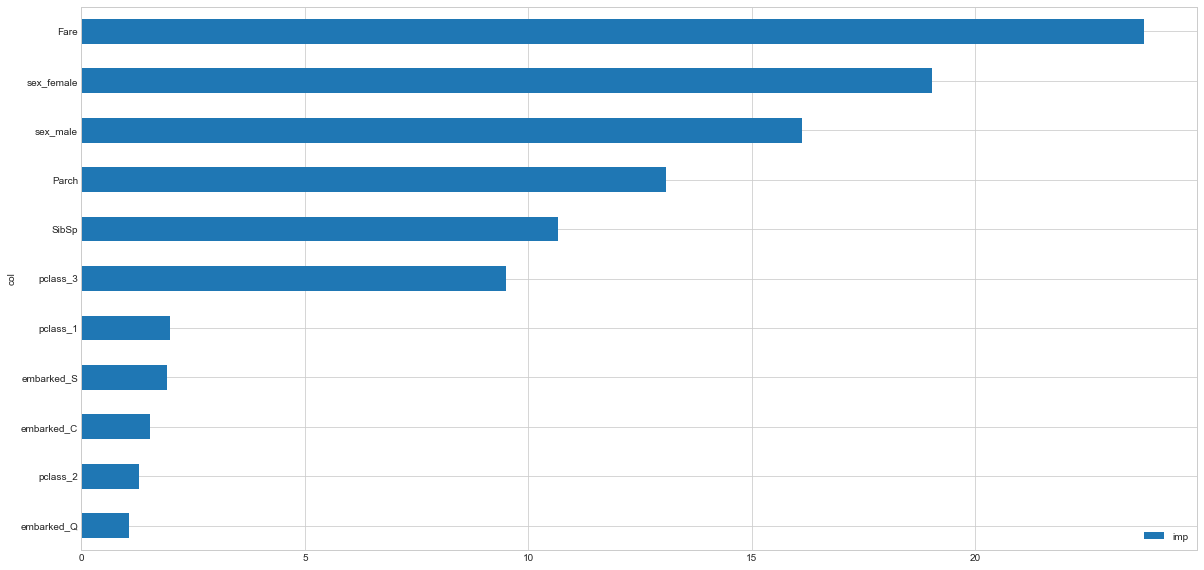

In [137]:
feature_importance(catboost_model,X_train)

In [138]:
metrics = ['Precision','Recall','F1','AUC']
eval_metrics = catboost_model.eval_metrics(train_pool,metrics=metrics,plot=True)
for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8618188602491055
Recall: 0.6814385964912281
F1: 0.7609644391691813
AUC: 0.8954454936673804


In [153]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title
0,892,3,male,22,0,0,330911,7.8292,Q,8,1
1,893,3,female,38,1,0,363272,7.0000,S,8,3
2,894,2,male,26,0,0,240276,9.6875,Q,8,1
3,895,3,male,35,0,0,315154,8.6625,S,8,1
4,896,3,female,35,1,1,3101298,12.2875,S,8,3


In [154]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'],prefix='embarked')
test_sex_one_hot = pd.get_dummies(test['Sex'],prefix='sex')
test_pclass_one_hot = pd.get_dummies(test['Pclass'],prefix='pclass')

In [158]:
test = pd.concat([test,
                 test_embarked_one_hot,
                 test_sex_one_hot,
                 test_pclass_one_hot],axis=1)

In [159]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,male,22,0,0,330911,7.8292,Q,8,1,0,1,0,0,1,0,0,1
1,893,3,female,38,1,0,363272,7.0000,S,8,3,0,0,1,1,0,0,0,1
2,894,2,male,26,0,0,240276,9.6875,Q,8,1,0,1,0,0,1,0,1,0
3,895,3,male,35,0,0,315154,8.6625,S,8,1,0,0,1,0,1,0,0,1
4,896,3,female,35,1,1,3101298,12.2875,S,8,3,0,0,1,1,0,0,0,1


In [160]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Fare', 'SibSp', 'Parch', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [161]:
predictions = catboost_model.predict(test[wanted_test_columns])

In [162]:
predictions[:20]

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1.])

In [163]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions
submission.head()


,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [164]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [165]:
submission['Survived'] = submission['Survived'].astype(int)

In [166]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [176]:
submission.to_csv("prediction.csv",index=False)

In [177]:
submission_check = pd.read_csv("prediction.csv")
submission_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [178]:
len(submission_check)

418